In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils.data_utils import preprocess_and_normalize_energy_data

# Loading and aggregating the data

In [17]:
df_unnormalized = pd.read_csv('../data/architectures-energies-parsed.csv')
df = preprocess_and_normalize_energy_data(df_unnormalized,['module','batch_size','architecture','layer_idx'], aggregate=True)
df.head()

Shape before aggregation: (630, 36), after aggregation: (630, 27) (non numeric columns removed)


,module,batch_size,architecture,layer_idx,Unnamed: 0,duration,emissions,emissions_rate,cpu_power,gpu_power,...,cloud_region,cpu_count,gpu_count,gpu_model,longitude,latitude,ram_total_size,rep_no,macs,forward_passes
0,AlexNet,157,alexnet,0,0.0,1.251010,1.795111e-06,0.001435,56.536917,0.0,...,NaN,12.0,NaN,NaN,9.6014,47.2318,15.253563,1.0,1.123432e+11,2.0
1,Conv2d,157,alexnet,1,1.0,1.069108,1.654465e-06,0.001548,61.414938,0.0,...,NaN,12.0,NaN,NaN,9.6014,47.2318,15.253563,1.0,1.316690e+10,9.0
2,ReLU,157,alexnet,2,2.0,1.005410,3.825318e-07,0.000380,10.798629,0.0,...,NaN,12.0,NaN,NaN,9.6014,47.2318,15.253563,1.0,3.617280e+07,71.0
3,MaxPool2d,157,alexnet,3,3.0,1.013570,1.240313e-06,0.001224,47.368785,0.0,...,NaN,12.0,NaN,NaN,9.6014,47.2318,15.253563,1.0,3.802666e+07,20.0
4,Conv2d,157,alexnet,4,4.0,1.101578,1.838203e-06,0.001669,66.672028,0.0,...,NaN,12.0,NaN,NaN,9.6014,47.2318,15.253563,1.0,4.058712e+10,7.0


# Analysis

In [18]:
# compute % contribution
module_wise_contributions_by_architecture = pd.DataFrame(columns=['architecture','module','batch_size','cpu_energy','percent_contribution'])
for a in df.architecture.unique():
    # subset data by architecture
    sub = df.loc[df.architecture == a]
    total_measured_energies = []
    total_agg_energies = []
    for b in sub.batch_size.unique():
        # subset data by batch_size
        sub_b = sub.loc[sub.batch_size == b]
        # get energy from complete architecture run
        total_measured_energy = sub_b.loc[sub_b.layer_idx == 0].cpu_energy.item()
        # subset only data from individual modules of architecture
        sub_b = sub_b.loc[sub_b.layer_idx != 0]
        # compute empirical total energy from complete architecture run by summing up modules
        sub_b = sub_b.groupby(['architecture','batch_size','module'])['cpu_energy'].sum().reset_index()
        total_agg_energy = sum(sub_b.cpu_energy)
        # compute % contribution of module to total energy consumption
        sub_b["percent_contribution"] = round(sub_b.cpu_energy / total_agg_energy * 100, 2)
        module_wise_contributions_by_architecture = pd.concat([module_wise_contributions_by_architecture, sub_b], ignore_index=True)
        # store values
        total_agg_energies.append(total_agg_energy)
        total_measured_energies.append(total_measured_energy)
    # print avg energies; compare energy when running the full architecture vs summing the energy over the individual modules
    print(f"{a}: avg. total-measured-energy: {np.round(np.mean(total_measured_energies),10)}, avg. total-agg-energy: {np.round(np.mean(total_agg_energies),10)}, resulting deviation: {np.round(np.mean([(b - a) / b for a, b in zip(total_measured_energies, total_agg_energies)]),2)*100}%")

alexnet: avg. total-measured-energy: 8.6426e-06, avg. total-agg-energy: 1.01246e-05, resulting deviation: 16.0%
vgg11: avg. total-measured-energy: 8.69022e-05, avg. total-agg-energy: 0.0001091451, resulting deviation: 21.0%
vgg13: avg. total-measured-energy: 0.0001031842, avg. total-agg-energy: 0.0001292192, resulting deviation: 19.0%
vgg16: avg. total-measured-energy: 0.0002048693, avg. total-agg-energy: 0.0002521555, resulting deviation: 19.0%


# Plotting

black line shows deviations between batch-sizes


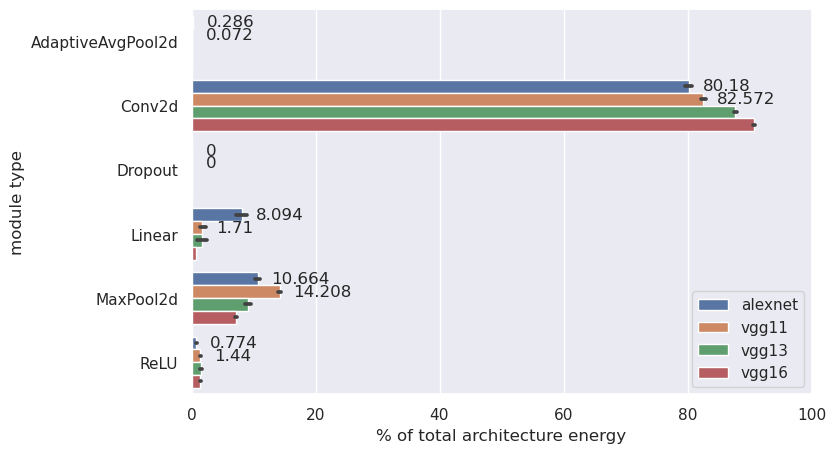

In [19]:
plt.figure(figsize=(8,5))
g = sns.barplot(data=module_wise_contributions_by_architecture, x="percent_contribution",y="module",hue="architecture")
g.bar_label(g.containers[0], padding=10)
g.bar_label(g.containers[1], padding=10)
g.set_xlim(0, 100)
plt.legend(loc="lower right")
plt.ylabel("module type")
plt.xlabel("% of total architecture energy")
print("black line shows deviations between batch-sizes")

Text(0, 0.5, '% of total architecture energy')

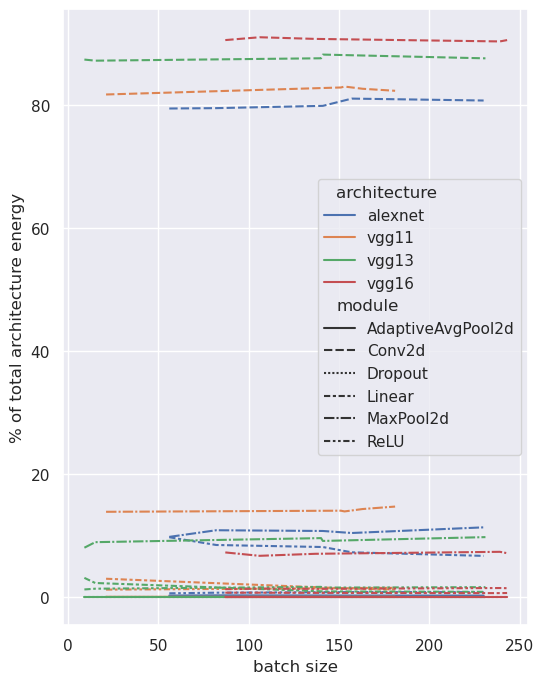

In [20]:
plt.figure(figsize=(6,8))
sns.lineplot(data=module_wise_contributions_by_architecture, x="batch_size", y="percent_contribution", hue="architecture",style="module")
plt.xlabel("batch size")
plt.ylabel("% of total architecture energy")